# camera_calib_python

This is a python based camera calibration "library". Some things:

* Uses [nbdev](https://github.com/fastai/nbdev), which is an awesome and fun way to develop and tinker.
* Uses pytorch for optimization of intrinsic and extrinsic parameters. Each step in the model is modularized as its own pytorch `nn.module` in the `modules.ipynb` notebook. 
    * Optimization is carried out via the built in `LBFGS` optimizer. The `LBFGS` optimizer uses only the gradient to do a quasi second order optimization. However, I've noticed it's imperfect and can a take long time to converge in some cases.
    * The use of pytorch allows the forward pass to be easily modified. It also allows the use of any differentiable loss function although I've noticed that sum of squared errors seems to give the best results of the losses I've tried.
* The fiducial point detector for my calibration board uses a pytorch neural net under the hood (more info [here](https://github.com/justinblaber/fiducial_detect)), which is easily integrated into this library since its python based.

# Example

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt

from camera_calib_python.calib import calib_multi, draw_bipartite
from camera_calib_python.cb_geom import CbGeom, CpCSRGrid, FmCFPGrid
from camera_calib_python.control_refine import OpenCVCheckerRefiner
from camera_calib_python.fiducial_detect import DotVisionCheckerDLDetector
from camera_calib_python.image import File16bitImg
from camera_calib_python.plot import plot_extrinsics

Before calibration can be done, we need the following information:

1. Calibration board geometry
2. Fiducial point detector
3. Control point refiner
4. Images and their respective camera and pose indices

1) The first thing to do is define a calibration board geometry. This specifies where fiducial markers and control points are located. For this example, my dot vision checker board is used.

In [2]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

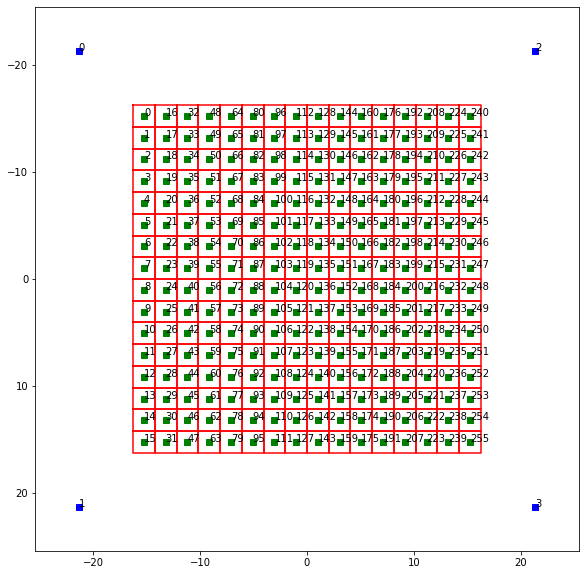

In [3]:
cb_geom.plt()

2) A fiducial detector needs to be specified. This fiducial detector will take in an image and return the locations of the fiducial markers. The detector in this example is a neural net trained specifically on my calibration board. More info available at:

* https://github.com/justinblaber/fiducial_detect

In [4]:
file_model = Path('models/dot_vision_checker.pth')
detector = DotVisionCheckerDLDetector(file_model)

3) The refiner will take in an image, initial guesses for control points, and the boundaries around the control points. These boundaries help determine how much neighboring info can be used to refine the control point.

In [5]:
refiner = OpenCVCheckerRefiner(hw_min=5, hw_max=15, cutoff_it=20, cutoff_norm=1e-3)

4) Get images and respective camera and pose indices from the file name

In [6]:
files_img = list(Path('data/dot_vision_checker').glob('*.png'))
files_img

[PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1.png')]

In [7]:
def _parse_name(name_img):
    match = re.match(r'''SERIAL_(?P<serial>.*)_
                         DATETIME_(?P<date>.*)_
                         CAM_(?P<cam>.*)_
                         FRAMEID_(?P<frameid>.*)_
                         COUNTER_(?P<counter>.*).png''', 
                     name_img, 
                     re.VERBOSE)
    return match.groupdict()

In [8]:
imgs = []
for file_img in files_img:
    dict_group = _parse_name(file_img.name)
    img = File16bitImg(file_img)
    img.idx_cam = int(dict_group['cam'])-1
    img.idx_pos = int(dict_group['counter'])-1
    imgs.append(img)

In [9]:
for img in imgs: print(f'{img.name} - cam: {img.idx_cam} - pos: {img.idx_pos}')

SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2 - cam: 1 - pos: 1
SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1 - cam: 0 - pos: 0
SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1 - cam: 2 - pos: 0
SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2 - cam: 2 - pos: 1
SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1 - cam: 1 - pos: 0


Now, we can calibrate

In [10]:
cams, distorts, rigids_pos, rigids_cam, debug = calib_multi(imgs, cb_geom, detector, refiner)

Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1...
Refining single parameters...
 - Iteration: 000 - Norm:    0.00483 - Loss:    5.36058
 - Iteration: 001 - Norm:    0.15146 - Loss:    3.71881
 - Iteration: 002 - Norm:    3.92902 - Loss:    3.49835
 - Iteration: 003 - Norm:    7.61183 - Loss:    3.26027
 - Iteration: 004 - Norm:   53.26645 - Loss:    1.69542
 - Iteration: 005 - Norm:    0.00000 - Loss:    1.69542
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2...
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1...
Refining single parameters...
 - Iteration: 000 - Norm:    0.04100 - Loss:  145.66077
 - Iteration: 001 - Norm:    0.13687 - Loss:   83.93632
 - Iteration: 002 - Norm:    0.84322 - Loss:    3.98970
 - Iteration: 003 - Norm:    0.27753 - Loss:    3.59056
 - Iteration: 004 - Norm:    6.16048 - Loss:    3.

From Bo Li's calibration paper, we know the coordinate graph of poses and cameras forms a bipartite graph. For debugging purposes this is displayed below.

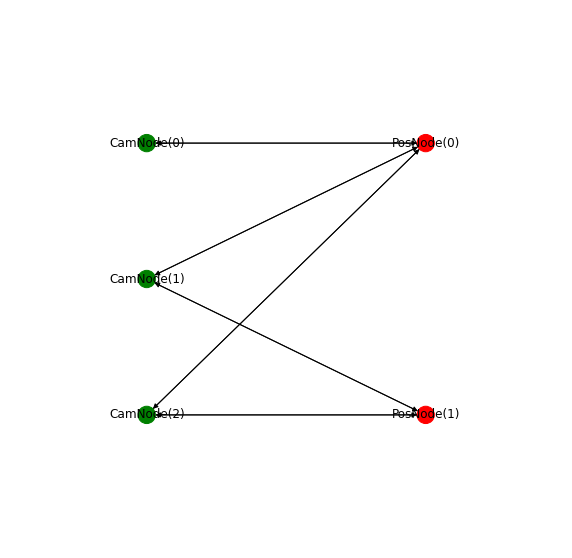

In [11]:
draw_bipartite(*debug[2:])

Plot refined and model control points

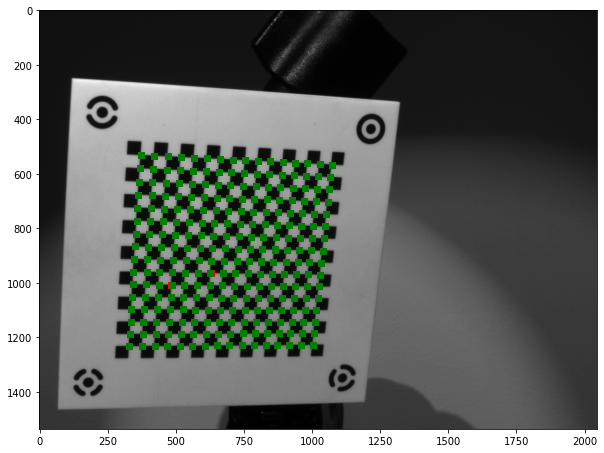

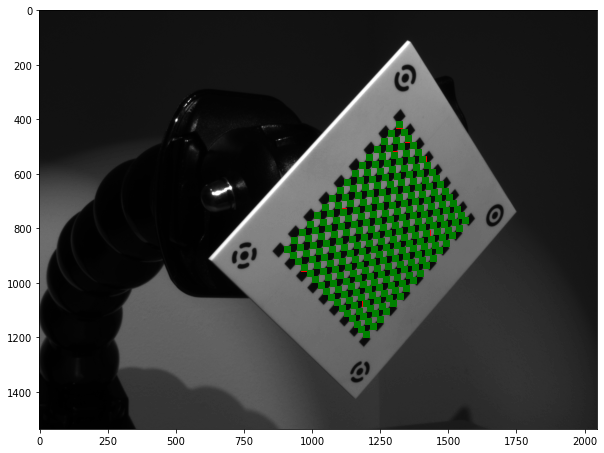

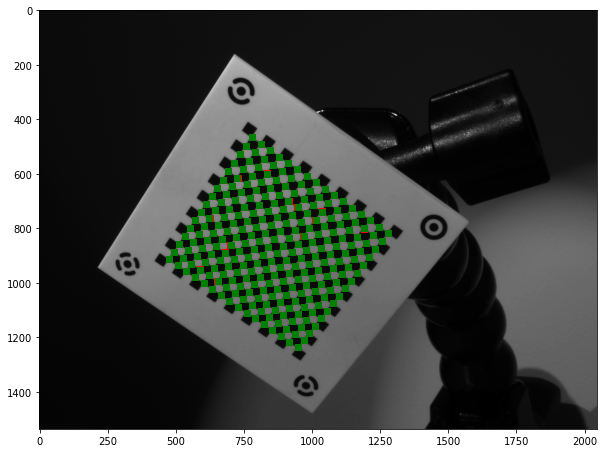

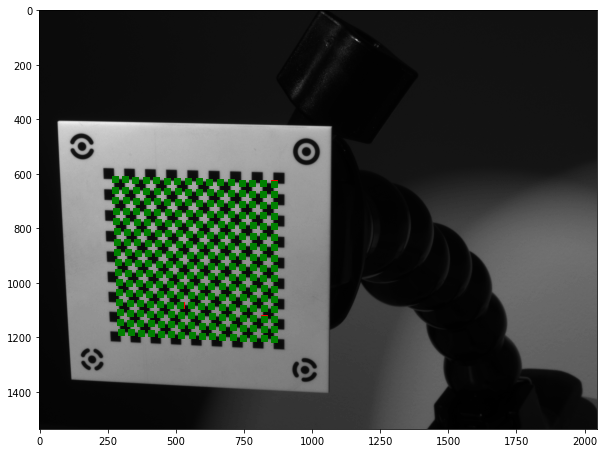

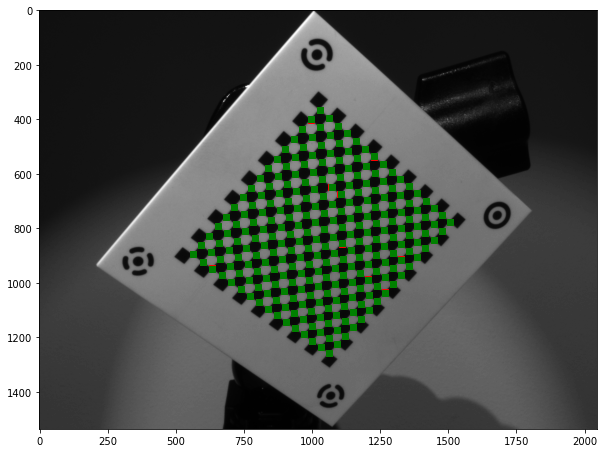

In [12]:
for idx, img in enumerate(imgs):
    plt.figure(idx, figsize=(10,10))
    plt.imshow(img.array_gs, cmap='gray')
    plt.plot(debug[0][idx][:,0], debug[0][idx][:,1], 'rs')
    plt.plot(debug[1][idx][:,0], debug[1][idx][:,1], 'gs')

Plot residuals

(-0.25, 0.25)

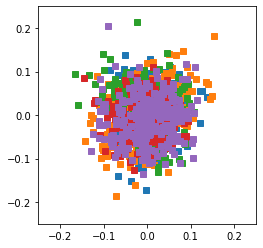

In [13]:
for p1, p2 in zip(debug[0], debug[1]):
    res = (p1-p2)
    plt.plot(res[:,0], res[:,1], 's')
plt.gca().set_aspect(1)
plt.gca().set_xlim(-0.25, 0.25)
plt.gca().set_ylim(-0.25, 0.25)

Plot extrinsics; note that `%matplotlib notebook` can be used to make the plot interactive

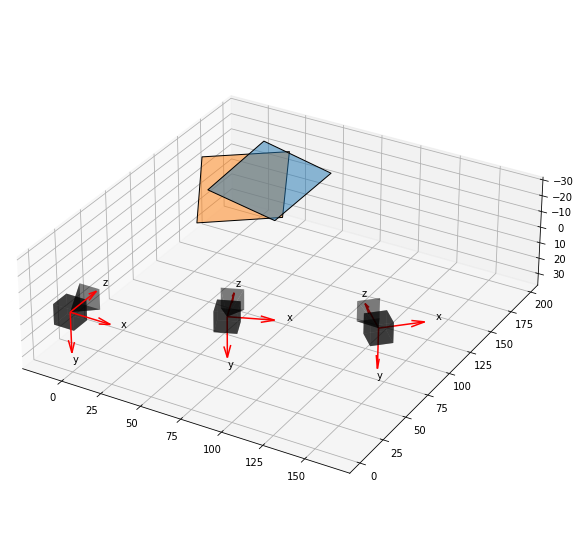

In [14]:
plot_extrinsics(rigids_pos, rigids_cam, cb_geom)

Makes sense!

# Build

In [15]:
!jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 10345 bytes to README.md
